In [1]:
# Mounting the google drive to get the images

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing libraries

from PIL import Image # Used for displaying images and perform some tasks
from io import BytesIO # Used to perform bytewise operation on images from web
import matplotlib.pyplot as plt # Plotting purpose
import numpy as np 

import torch
import torch.optim as optim
import requests # Used when image path is given in a https request form
from torchvision import transforms,models # Used for transforming and in transfer learning

In [3]:
def load_image(img_path,max_size=400,shape=None):

  ''' Loading and transforming an image given that the max width
  or height is 400px '''

  # Loading the image from the path
  if 'http' in img_path:
    response = requests.get(img_path)
    image = Image.open(BytesIO(response.content)).convert('RGB')

  else:
    image = Image.open(img_path).convert('RGB')


  # Checking size and limiting it to 400px

  if max(image.size) > max_size:
    size = max_size

  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  # Transforming the image into tensor and also normalizing it

  im_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), 
                            (0.229, 0.224, 0.225))
      ])

  # Unsqueezing the image for better and faster implementation

  image = im_transform(image)[:3,:,:].unsqueeze(0)

  return image


# Un-normalizing the tensor and changing it back to a numpy array for easy image view

def im_convert(tensor):

  '''
  Displays tensor as an image

  '''

  image = tensor.to('cpu').clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0) 

  # Un-nomalizing the previously normalized tensor

  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0,1)

  return image

# A function to display multiple images on a single plot

def display_images(content,style):

  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10),)
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(style))

# Getting features for our image using a pre trained model

def get_features(image,model,layers=None):

  # Listing useful layers for our target images
  # We will use the 21st layer for content feature and the other
  # for style feature

  if layers is None:
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1', 
        '10': 'conv3_1', 
        '19': 'conv4_1',
        '21': 'conv4_2',  
        '28': 'conv5_1'
    }

  # Getting a feature matrix for our image
  # The feature matrix consists of layer names and tensor feature

  features = {}
  x = image

  for name,layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features

# Calculating gram matrix for a given tensor

def gram_matrix(tensor):

  b,d,h,w = tensor.size()
  tensor = tensor.view(b*d,h*w)

  gram = torch.mm(tensor,tensor.t())

  return gram

In [5]:
# Lets use vgg model for our features extraction
# Vgg model has two parts the classifier and feature part
# The classifier is the dense layer where as the feature part is the cnn
# We extract the feature part from the vgg network and freeze them not to be trained

vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

In [6]:
# Printing out the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
# Creating a content and style image tensor

content = load_image('drive/MyDrive/style_transfer_images/Arsenal.png').to(device)
style = load_image('drive/MyDrive/style_transfer_images/sunset.jpg',shape=content.shape[-2:]).to(device)
print(content.shape)
print(style.shape)

torch.Size([1, 3, 210, 373])
torch.Size([1, 3, 210, 373])


 
      
        This is the style image

          


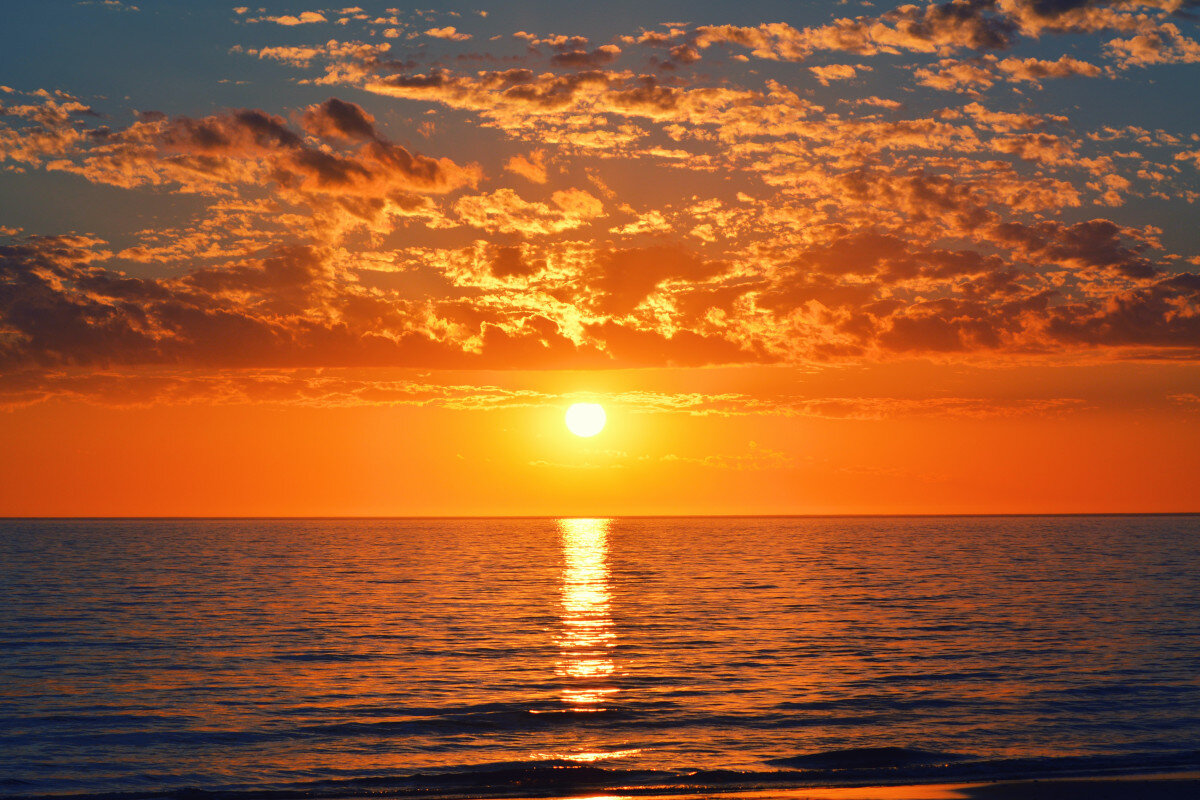

In [8]:
# Lets see the raw style image

print(''' 
      \n\t\t================
        This is the style image
        ================\n
          ''')
Image.open('drive/MyDrive/style_transfer_images/sunset.jpg')

 
      
        This is the content image

          


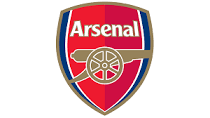

In [9]:
# Lets see the raw content image

print(''' 
      \n\t\t================
        This is the content image
        ================\n
          ''')
Image.open('drive/MyDrive/style_transfer_images/Arsenal.png')

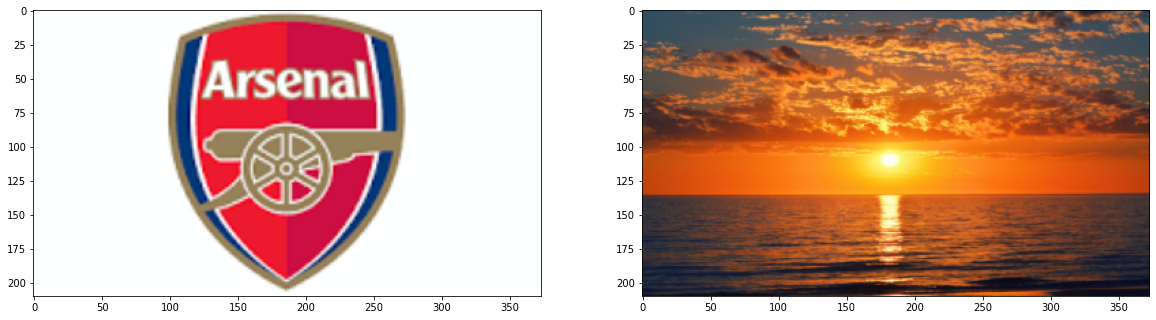

In [10]:
# Displaying the content and display image after transformation

display_images(content,style)

In [11]:
# Lets print the vgg feature names

for name,layers in vgg._modules.items():
  print(name,layers)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

In [12]:
# Creating a style gram and target for training

content_features = get_features(content,vgg)
style_features = get_features(style,vgg)

style_grams = {}

for layer in style_features:
  style_grams[layer] = gram_matrix(style_features[layer])

target = content.clone().requires_grad_(True).to(device)


In [13]:
# Listing out the names of the style gram keys i.e. layers of the feature matrix

style_grams.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

In [14]:
# Initializing weights for each layer to speed up the training

style_weights = {
    'conv1_1':1,
    'conv2_1':0.75,
    'conv3_1':0.5,
    'conv4_1':0.25,
    'conv5_1':0.2,
}


content_weight = 1 # Alpha
style_weight = 1e8 # Beta

Total loss:  4838043136.0


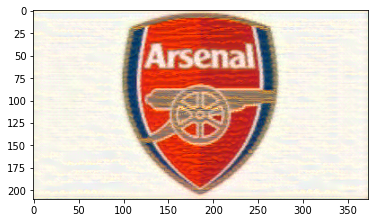

Total loss:  2491026432.0


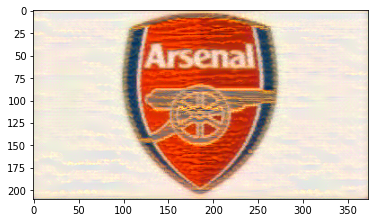

In [ ]:
# Creating a display interval of the image

show_every = 500

# Using Adam optimizer and updating the target image based on the target losses

optimizer = optim.Adam([target],lr = 0.003)

# Initializing an epoch

steps = 2000

for step in range(1,steps+1):

  # Creating feature dictionary for the target image

  target_features = get_features(target,vgg)

  # calculating the content loss by making the 21st convolutional layer
  # as a feature vector of both the target and content

  content_loss = torch.mean(
      (target_features['conv4_2'] - content_features['conv4_2'])**2)
  
  # Initializing the style loss

  style_loss = 0.0

  # Looping through all the layers to get the style feature matrix

  for layer in style_weights:

    # Getting the feature and gram matrix for the target

    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)

    b,d,h,w = target_feature.shape

    # Calculating the gram for the style image

    style_gram = style_grams[layer]

    # Calculating the style loss of the target image and the style image

    layer_style_loss = style_weights[layer] * torch.mean(
        (target_gram - style_gram)**2
        )
    
    # Updating and averaging the style loss

    style_loss += layer_style_loss / (d*h*w)

  # Using alpha and beta for calculating the total loss

  total_loss = content_loss * content_weight + style_loss * style_weight

  # Clearing the cache of the optimizer grads

  optimizer.zero_grad()

  # Backward propagation

  total_loss.backward()

  # Updating the weigths

  optimizer.step()

  # Displaying the target image after some itterations
  
  if step % show_every == 0:
    print('Total loss: ', total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()


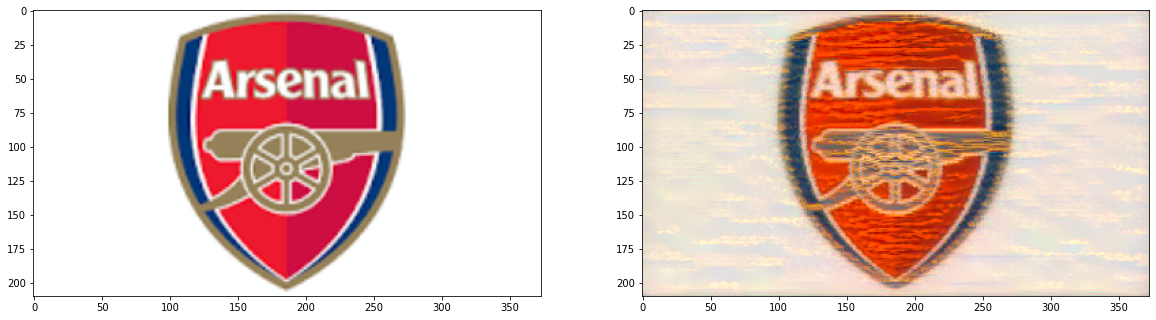

In [96]:
# Displaying the result

display_images(content,target)